# Brain Disorder Diagnosis

In this tutorial, we demonstrate how to leverage **patient phenotypic information** to reduce **site-specific biases** in functional connectivity data using **domain adaptation**, with the goal of improving **multi-site autism classification**.

This notebook builds on the work of **Kunda et al. (IEEE TMI, 2022)**, which introduced a second-order functional connectivity representation called **Tangent-Pearson**, the tangent embedding of the Pearson correlation matrix. The original work also applied domain adaptation to reduce site dependencies in fMRI-derived features, using **site labels** as the domain information.

We extend this approach by incorporating a **richer set** of phenotypic variables, such as sex, handedness, age, and eye status into the domain adaptation framework. This enables more effective harmonization across data collected from different imaging sites.

---

**Objectives**

1.	**Load** the ABIDE dataset using different preprocessing pipelines and brain atlases.
2.	**Preprocess** phenotypic variables for use in domain adaptation, and obtain class labels (ASD vs CONTROL) and site labels.
3.	**Extract** functional connectivity **embedding** from ROI-based time series.
4.	**Build** a **training** and **evaluation** pipeline to assess classification performance under various domain adaptation strategies.
5.	**Interpret** the learned model by extracting weights for pairwise ROI feature importance and visualizing them using a connectome plot.

# Setup

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

In addition, several helper scripts are provided to modularize the code and simplify the workflow. These can be inspected directly as `.py` files in the notebook’s current directory. The helper scripts include:

- **`config.py`**: Defines the base configuration settings, which can be customized and overridden using external `.yml` files.
- **`data.py`**: Provides data loading functions and utilities to automatically download any required datasets.
- **`parsing.py`**: Contains utilities to compile and summarize evaluation results from the training process.
- **`preprocess.py`**: Handles phenotype preprocessing, including missing value imputation, categorical variable encoding, and feature extraction from fMRI time series data.

In [ ]:
import os
import site
import sys
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

if "google.colab" in str(get_ipython()):
    sys.path.insert(0, site.getusersitepackages())
    !git clone --single-branch https://github.com/pykale/embc-mmai25.git
    %cp -r /content/embc-mmai25/tutorials/brain-disorder-diagnosis/* /content/
    %rm -r /content/embc-mmai25

## Packages

The main packages required for this tutorial are:

- **pykale**: An open-source interdisciplinary machine learning library developed at the University of Sheffield. It focuses on applications in biomedical and scientific domains, providing tools for multimodal learning, domain adaptation, and model interpretability.

- **gdown**: A utility package that simplifies downloading files and folders directly from Google Drive.

- **nilearn**: A Python library for neuroimaging analysis. It offers convenient tools for processing, analyzing, and visualizing functional MRI (fMRI) data.

- **yacs**: A lightweight configuration management library used to store and organize experiment settings in a hierarchical and human-readable format.

In [ ]:
!pip install --quiet --user \
    git+https://github.com/pykale/pykale@main \
    gdown==5.2.0 nilearn==0.10.4 yacs==0.1.8 \
    && echo "pykale, gdown, nilearn, and yacs installed successfully ✅" \
    || echo "Failed to install pykale, gdown, nilearn, and yacs ❌"

pykale, gdown, nilearn, and yacs installed successfully ✅


## Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a `config.py` file that defines default parameters. These can be customized by supplying a `.yml` configuration file, such as `experiments/base.yml` as an example.

Please refer to these files for detailed instructions on how to customize the experiment settings.  
We provide detailed descriptions of each configurable option in the following sections.

In [ ]:
from config import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file("experiments/base.yml")
cfg.freeze()
print(cfg)

CROSS_VALIDATION:
  NUM_FOLDS: 10
  NUM_REPEATS: 1
  SPLIT: skf
DATASET:
  ATLAS: hcp-ica
  FC: tangent-pearson
  PATH: data
PHENOTYPE:
  STANDARDIZE: site
RANDOM_STATE: 0
TRAINER:
  CLASSIFIER: lr
  NONLINEAR: False
  NUM_SEARCH_ITER: 20
  NUM_SOLVER_ITER: 100
  N_JOBS: -1
  PRE_DISPATCH: 2*n_jobs
  REFIT: accuracy
  SCORING: ['accuracy', 'roc_auc']
  SEARCH_STRATEGY: random
  VERBOSE: 0


# Data Loading and Preprocessing

Typically, raw fMRI scans require extensive preprocessing before they can be used in a machine learning pipeline. However, the **ABIDE** dataset provides several preprocessed derivatives, which can be downloaded directly from the [Preprocessed Connectomes Project (PCP)](https://preprocessed-connectomes-project.org/abide/), eliminating the need for manual preprocessing.

Given the long runtime required to extract the functional connectivity embedding, we will omit this step from this notebook and provide pre-computed embeddings through the provided `load_data` function with the associated atlas.

For users interested in computing the time series and functional connectivity embeddings from scratch, assuming preprocessed images are available, please refer to:

- [`NiftiLabelsMasker` (Deterministic / 3D Atlas)](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiLabelsMasker.html)
- [`NiftiMapsMasker` (Probabilistic / 4D Atlas)](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiMapsMasker.html)
- `extract_functional_connectivity` function implemented in `preprocess.py`.

In this tutorial, we focus on the following preprocessing options:

- **`path`** (or `data_dir`): Directory where the preprocessed dataset is located.
  - *Default:* Current working directory + `/data`

- **`atlas`**: The brain atlas used to extract ROI time series.
  - Available options:
    - `"aal"`: AAL Atlas
    - `"cc200"`: Cameron Craddock 200
    - `"cc400"`: Cameron Craddock 400
    - `"difumo64"`: DiFuMo 64
    - `"dos160"`: Dosenbach 160
    - `"hcp-ica"`: HCP-ICA
    - `"ho"`: Harvard-Oxford
    - `"tt"`: Talairach-Tournoux  
  - *Default:* `"cc200"`

- **`fc`**: The functional connectivity measure used to compute pairwise associations between ROIs.
  - Available options:
    - `"pearson"`: Pearson correlation
    - `"partial"`: Partial correlation
    - `"tangent"`: Tangent embedding
    - `"precision"`: Precision (inverse covariance)
    - `"covariance"`: Covariance
    - `"tangent-pearson"`: Tangent-Pearson hybrid connectivity  
  - *Default:* `"tangent-pearson"`

In [ ]:
from data import load_data

fc, phenotypes, rois, coords = load_data(
    cfg.DATASET.PATH, cfg.DATASET.ATLAS, cfg.DATASET.FC
)

✔ File found: data/abide/fc/hcp-ica/tangent-pearson.npy
✔ File found: data/abide/phenotypes.csv
✔ Atlas folder found: data/atlas/deterministic/hcp-ica


## Phenotype Preprocessing

The phenotypic information in the dataset contains several missing values. We impute and encode these variables to make them suitable for modeling. The `preprocess_phenotypic_data` function handles this functionality for us.

### Categorical Variables

The following categorical phenotypes are used and will be **one-hot encoded**:

- `SITE_ID`
- `SEX`
- `HANDEDNESS_CATEGORY`
- `EYE_STATUS_AT_SCAN`

### Continuous Variables

The following continuous phenotypes will optionally be **standardized**:

- `AGE_AT_SCAN`
- `FIQ`

Standardization options for continuous phenotypes (`standardize` argument):

- `"all"` or `True`: Standardize across all subjects.
- `"site"`: Standardize within each site.
- `False`: No standardization.

### Handling Missing Values

- `HANDEDNESS_CATEGORY`: Missing values are assumed to correspond to `right-handed` subjects.
- `FIQ`: Missing values are imputed with a default score of `100`.

### Label Encoding

The diagnostic label `DX_GROUP` is used to assign the target class:

- `CONTROL` → `0`
- `ASD` → `1`

In [ ]:
from preprocess import preprocess_phenotypic_data

labels, sites, phenotypes = preprocess_phenotypic_data(
    phenotypes, cfg.PHENOTYPE.STANDARDIZE
)

# Modeling

We define and train machine learning models for classifying autism spectrum disorder (ASD) using functional connectivity features.

We explore different configurations including a baseline model, domain adaptation using site information, and an extended approach that incorporates additional phenotypic variables.

Each model is evaluated using cross-validation, and we analyze the impact of domain adaptation on classification performance.

### Cross-Validation Split

To evaluate model performance reliably, we define a cross-validation (CV) strategy. By default, we use **Repeated Stratified K-Fold**, which preserves class distribution across folds and supports repeated trials for more stable estimates.

Alternatively, we can also use **Leave-P-Groups-Out (LPGO)** cross-validation. This strategy is particularly useful in multi-site studies, as it ensures that data from the same group (e.g., imaging site) are not shared between training and test sets, enabling more realistic generalization assessment under domain shift.

In this tutorial, we specify the following arguments:

- **`split`**: Defines the cross-validation strategy.
  - Available options: 
    - `"skf"`: Stratified K-Fold to maintain label balance in each fold.
    - `"lpgo"`: Leave-P-Groups-Out to evaluate generalization across sites by holding out entire groups (e.g., imaging sites).
  - *Default:* `"skf"`

- **`num_folds`**: The number of folds for Stratified K-Fold or the number of groups to leave out in LPGO.
  - *Default:* `10`

- **`num_repeats`**: The number of times the k-fold procedure is repeated to obtain more stable estimates (ignored when using LPGO).
  - *Default:* `5`

- **`random_state`**: Seed for random number generators for reproducibility.
  - *Default:* `None`

In [ ]:
from sklearn.model_selection import LeavePGroupsOut, RepeatedStratifiedKFold

# Define the default cross-validation strategy:
# Repeated stratified k-fold maintains class distribution across folds and supports multiple repetitions
cv = RepeatedStratifiedKFold(
    # Number of stratified folds
    n_splits=cfg.CROSS_VALIDATION.NUM_FOLDS,
    # Number of repeat rounds
    n_repeats=cfg.CROSS_VALIDATION.NUM_REPEATS,
    # Ensures reproducibility, intentionally set to the seed to have the same splits across runs
    random_state=cfg.RANDOM_STATE,
)

# Override with leave-p-proups-out if specified
# This strategy holds out `p` unique groups (e.g., sites) per fold, enabling group-level generalization
if cfg.CROSS_VALIDATION.SPLIT == "lpgo":
    # Use group-based CV for domain adaptation or site bias evaluation
    cv = LeavePGroupsOut(cfg.CROSS_VALIDATION.NUM_FOLDS)

### Model Definition

We define several model configurations used for classification. Each model shares the same base classifier but differs in how domain adaptation is applied:

- **Baseline**: A standard model trained directly on functional connectivity features without domain adaptation.
- **Site Only**: A domain-adapted model that uses site labels as the adaptation factor to reduce site-specific bias.
- **All Phenotypes**: An extended domain-adapted model that incorporates multiple phenotypic variables (e.g., age, sex, handedness) to further reduce inter-site variability.

We also specify the hyperparameter search strategy and other training parameters for each configuration, including:

- **`classifier`**: The base model used for classification.
  - Available options:
    - `"lda"`: Linear Discriminant Analysis
    - `"lr"`: Logistic Regression
    - `"linear_svm"`: Linear Support Vector Machine
    - `"svm"`: Kernel Support Vector Machine
    - `"ridge"`: Ridge Classifier (L2-regularized linear model)
    - `"auto"`: Automatically selects an appropriate model based on data characteristics.
  - *Default:* `"lr"`

- **`nonlinear`**: Whether to apply non-linear transformations (non-interpretable).
  - *Type:* `boolean`
  - *Default:* `False`

- **`search_strategy`**: The hyperparameter search method.
  - Available options:
    - `"random"`: Randomly search over finite iterations.
    - `"grid"`: Search over all possible combinations.
  - *Default:* `"random"`

- **`num_search_iterations`**: The number of hyperparameter combinations to evaluate in randomized search.
  - *Default:* `1,000`

- **`num_solver_iterations`**: The maximum number of iterations allowed for solver convergence.
  - *Default:* `1,000,000`

- **`scoring`**: A list of performance metrics used during cross-validation.
  - Available options:
    - `"accuracy"`: Accuracy
    - `"precision"`: Precision
    - `"recall"`: Recall
    - `"f1"`: F1-Score
    - `"roc_auc"`: Area Under ROC Curve (AUROC)
    - `"matthews_corrcoef"`: Matthews Correlation Coefficient (MCC)
  - *Default:* `["accuracy", "roc_auc"]`

- **`refit`**: The metric used to refit the best model after hyperparameter tuning.
  - *Default:* `"accuracy"`

- **`num_jobs`**: The number of CPU cores used for training and hyperparameter search.
  - Set to `-1` for all CPUs, `-k` for all but `k` CPUs.
  - *Default:* `-1`

- **`pre_dispatch`**: Controls job pre-dispatching for parallel execution.
  - *Default:* `"2*n_jobs"`

- **`verbose`**: Controls verbosity of training output.
  - *Default:* `0`

- **`random_state`**: Seed for random number generators for reproducibility.
  - *Default:* `None`

In [ ]:
from sklearn.base import clone
from kale.pipeline.multi_domain_adapter import AutoMIDAClassificationTrainer as Trainer

# Configuration with cv and random_state/seed included
trainer_cfg = {k.lower(): v for k, v in cfg.TRAINER.items()}
trainer_cfg = {**trainer_cfg, "cv": cv, "random_state": cfg.RANDOM_STATE}

# Initialize dictionary for different trainers
trainers = {}

# Create a baseline trainer without domain adaptation (MIDA disabled)
trainers["baseline"] = Trainer(use_mida=False, **trainer_cfg)

# Create a trainer with MIDA enabled, using site labels as domain adaptation factors
trainers["site_only"] = Trainer(use_mida=True, **trainer_cfg)

# Clone the 'site_only' trainer to create 'all_phenotypes' trainer
# This enables reusing the same training configuration, while modifying only the input domain factors
trainers["all_phenotypes"] = clone(trainers["site_only"])

# Training

We train each model configuration using the previously defined cross-validation strategy. The training process involves fitting the model on functional connectivity features and evaluating its performance using multiple scoring metrics (e.g., accuracy, F1-score, AUROC).

For models with domain adaptation, we pass additional domain factors (such as site or phenotypic variables) to guide the alignment of embedding. Cross-validation is performed to ensure robust performance estimates and to select the best hyperparameter configuration for each model.

In [ ]:
import pandas as pd
from tqdm import tqdm

# Define common training arguments for all models: features (X), labels (y), and group info (sites)
fit_args = {"x": fc, "y": labels, "groups": sites}

cv_results = {}
for model in (pbar := tqdm(trainers)):
    args = clone(fit_args, safe=False)
    if model == "site_only":
        args["group_labels"] = sites
    if model == "all_phenotypes":
        args["group_labels"] = phenotypes

    pbar.set_description(f"Fitting {model} model")
    trainers[model].fit(**args)
    cv_results[model] = pd.DataFrame(trainers[model].cv_results_)

Fitting all_phenotypes model: 100%|██████████| 3/3 [00:24<00:00,  8.19s/it]


# Evaluation

We evaluate and compare the performance of different model configurations using cross-validation results. We aggregate the top-performing scores for each model based on a specified evaluation metric (e.g., accuracy), allowing us to assess the effectiveness of domain adaptation strategies.

By comparing models with and without domain adaptation, we can determine the impact of incorporating site and phenotypic information on multi-site autism classification performance. This analysis helps identify which configurations generalize best across heterogeneous imaging sites.

In [ ]:
from parsing import compile_results

# Compile the cross-validation results into a summary table,
# sorting by the model with the highest test accuracy across CV folds
compiled_results = compile_results(cv_results, "accuracy")

# Display the compiled results DataFrame (models as rows, metrics as formatted strings)
display(compiled_results)

,Accuracy,AUROC
Model,,
Baseline,0.6629 ± 0.0523,0.7105 ± 0.0556
Site Only,0.6609 ± 0.0509,0.7127 ± 0.0596
All Phenotypes,0.6474 ± 0.0597,0.7057 ± 0.0514


# Interpretation

We interpret the trained models by analyzing the learned weights associated with functional connectivity features. Specifically, we extract the top-weighted ROI pairs that contributed most to the classification decision.

These weights are visualized as a **connectome plot**, allowing us to examine which brain region interactions are most informative for distinguishing individuals with autism from controls. This not only enhances the interpretability of the model but also provides potential insights into neurobiological patterns relevant to autism.

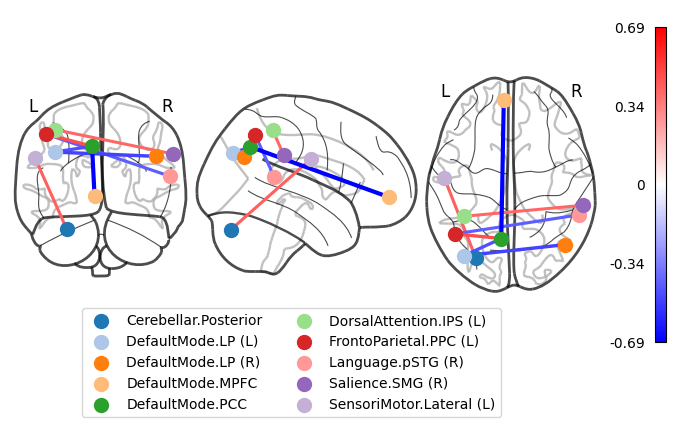

In [ ]:
import numpy as np
from kale.interpret.visualize import visualize_connectome

# Fetch coefficients to visualize feature importance
coef = trainers["site_only"].coef_.ravel()
# check if coef != features, assumes augmented features with phenotypes/sites
if coef.shape[0] != fc.shape[1]:
    coef, _ = np.split(coef, [fc.shape[1]])

# Visualize the coefficients as a connectome plot
proj = visualize_connectome(
    trainers["baseline"].coef_.ravel(),
    rois,
    coords,
    0.015,  # Take top 1.5% of connections
    legend_params={
        "bbox_to_anchor": (2.75, -0.1),  # Align legend outside the plot
        "ncol": 2,
    },
)

# Display the resulting connectome plot
display(proj)

### Interpretation of Discriminative Connectivity Patterns

This plot shows the **most discriminative ROI connections** for classifying ASD vs Control subjects.
- **Red edges** indicate connections **stronger in ASD**.
- **Blue edges** indicate connections **stronger in Control**.
- Color intensity reflects the **magnitude of contribution** to the model’s decision.

---

**Key Patterns**:

- **Default Mode Network (DMN)**:
    - *DefaultMode.MPFC*, *DefaultMode.PCC*, *DefaultMode.LP (L/R)*
    - Core hubs of the DMN, associated with **self-referential processing**, **social cognition**, and often disrupted in ASD.

- **Fronto-Parietal Network**:
    - *FrontoParietal.PPC (L)*
    - Involved in **executive function** and **cognitive flexibility**, domains typically impaired in ASD.

- **Dorsal Attention Network**:
    - *DorsalAttention.IPS (L)*
    - Associated with **goal-directed attention**, potentially altered in ASD subjects.

- **Salience Network**:
    - *Salience.SMG (R)*
    - Plays a role in **interoception** and **social-emotional processing**, relevant for ASD symptoms.

- **Language Network**:
    - *Language.pSTG (R)*
    - Critical for **language comprehension** and **social communication**, often affected in ASD.

- **Sensorimotor and Cerebellar Regions**:
    - *SensoriMotor.Lateral (L)*, *Cerebellar.Posterior*
    - Linked to **motor coordination** and **sensorimotor integration**, commonly atypical in ASD.

The interpretability analysis of the trained model highlights that **functional connectivity alterations across DMN, attention, salience, language, and sensorimotor systems** are key discriminative factors for distinguishing **ASD** from **Control** subjects.